In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create simulated data

In [3]:
n_spec = 1000
n_wavelengths = 300

In [4]:
def gaussian(x, mu, sigma):
    coeff = 1 / np.sqrt(2 * np.pi * sigma**2)
    return coeff * np.exp(-(x - mu)**2/(2 * sigma**2))

In [5]:
def add_spectral_line(spectra, wavelength_index, width, ampl = 0.1, emission = True):
    num_wavelengths, num_spec = spectra.shape
    sign = 1 if emission else -1
    line_fluxes = sign * np.random.uniform(2,5, num_spec)
    
    emission_line = gaussian(np.arange(n_wavelengths), wavelength_index, np.sqrt(width))

    return spectra + line_fluxes * np.repeat(np.expand_dims(emission_line,0), num_spec, axis=0).T

In [51]:
random_spectra = np.random.rand(n_wavelengths, n_spec)
spectra = add_spectral_line(random_spectra, 100, 5)
spectra = add_spectral_line(spectra, 210, 1)
spectra = add_spectral_line(spectra, 65, 0.5, emission=False)
total_spectra = add_spectral_line(spectra[:, :n_spec//2], 180, 1)
noise_spectra = spectra[:, n_spec//2:]
line_spectra = add_spectral_line(random_spectra*0.5, 180, 1)

# Visualize simulated data

In [50]:
def plot_random_spectra(spectra, shape = (3,3), ylims=(-2,2), figsize = (9,9)):
    num_spec = spectra.shape[0]
    
    fig, ax = plt.subplots(*shape, figsize=figsize)
    if shape[1] == 1:
        ax = np.expand_dims(ax, axis=1)
    if shape[0] == 1:
        ax = np.expand_dims(ax, axis=0)
    for i in range(shape[0]):
        for j in range(shape[1]):
            ax[i][j].plot(spectra[:,np.random.choice(num_spec)])
            ax[i][j].set_ylim(*ylims)

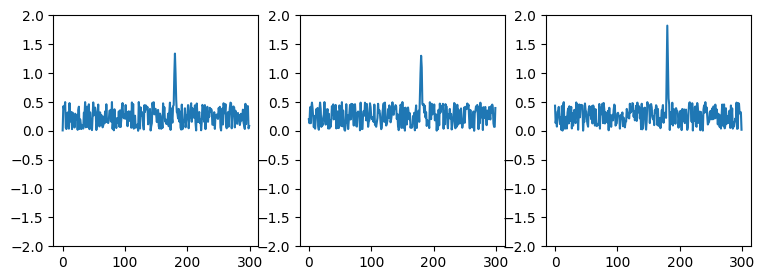

In [54]:
plot_random_spectra(line_spectra, shape=(1,3), figsize=(9,3))

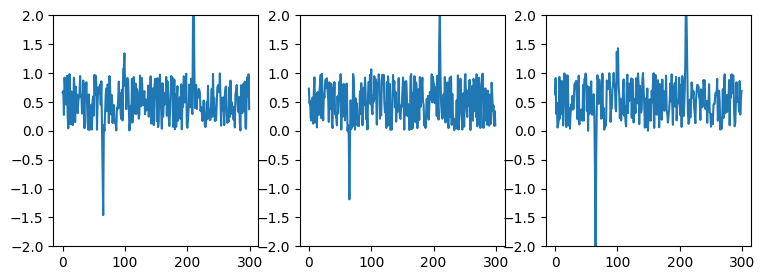

In [55]:
plot_random_spectra(noise_spectra, shape=(1,3), figsize=(9,3))

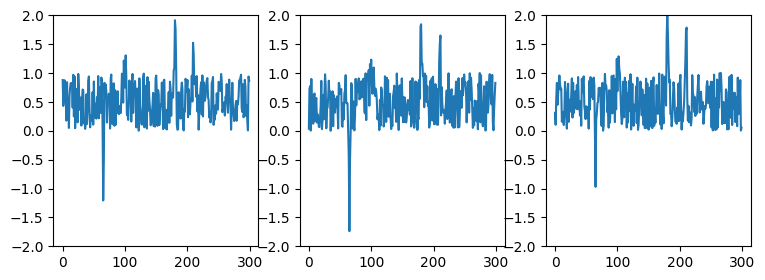

In [56]:
plot_random_spectra(total_spectra, shape=(1,3), figsize=(9,3))

# Calculate covariance matrices & separate components

Here we can use the MADGICS formulae:
$$
    X_i = C_i C_{tot}^{-1} X_{tot} \quad\text{where} \quad C_{tot} = \sum_{i = 0}^k C_i
$$

In [11]:
median_subtracted_line_spectra = line_spectra - np.median(line_spectra, axis= 0)
C_line = np.matmul(median_subtracted_line_spectra, median_subtracted_line_spectra.T) / line_spectra.shape[0]

median_subtracted_noise_spectra = noise_spectra - np.median(noise_spectra, axis= 0)
C_noise = np.matmul(median_subtracted_noise_spectra, median_subtracted_noise_spectra.T) / noise_spectra.shape[0]

Ctotinv = np.linalg.inv(C_line + C_noise)

In [12]:
median_subtracted_total_spectra = total_spectra - np.median(total_spectra, axis= 0)

extracted_lines = np.matmul(np.matmul(C_line, Ctotinv), median_subtracted_total_spectra)
extracted_noise = np.matmul(np.matmul(C_noise, Ctotinv), median_subtracted_total_spectra)

# Visualize components

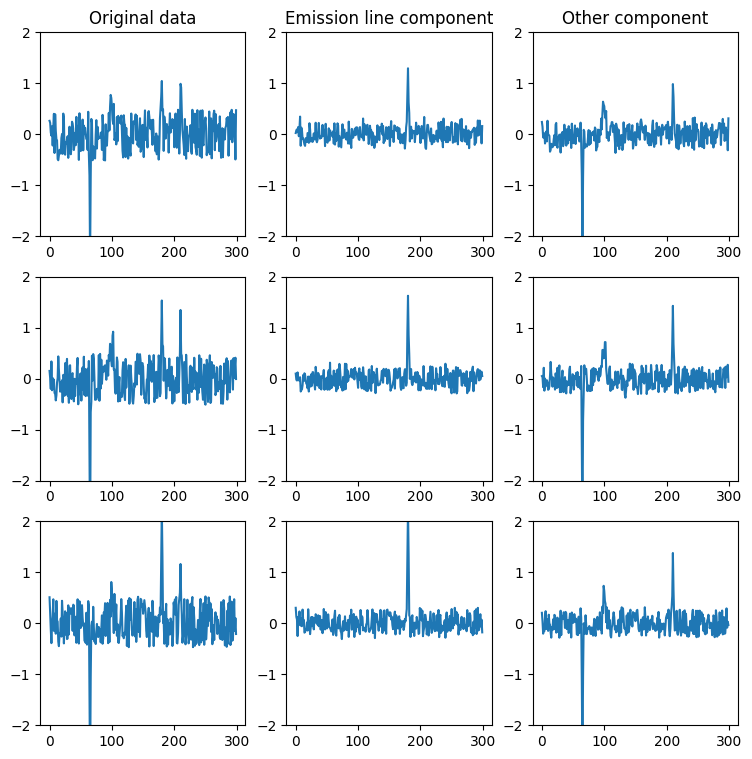

In [57]:
fig, ax = plt.subplots(3,3, figsize=(9,9))

for i in range(3):
    random_index = np.random.choice(np.arange(n_spec//2))
    ax[i][0].plot(median_subtracted_total_spectra[:,random_index])
    ax[i][1].plot(extracted_lines[:,random_index])
    ax[i][2].plot(extracted_noise[:,random_index])

ax[0][0].set_title("Original data")
ax[0][1].set_title("Emission line component")
ax[0][2].set_title("Other component")



plt.setp(ax, ylim=(-2,2))
plt.show()